# Model Evaluation

In [1]:
# Imports
import sys
import os
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve
)

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

# Import KhayatMiniNN
from KhayatMiniNN.neural_network import NeuralNetwork
from KhayatMiniNN.trainer import Trainer
from KhayatMiniNN.layers import LSTM, GRU, Conv1D, Dense, ReLU, Sigmoid, MaxPooling1D
from KhayatMiniNN.layers.base import Layer
from KhayatMiniNN.regularization import Dropout
from KhayatMiniNN.losses import BinaryCrossEntropy
from KhayatMiniNN.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

class Flatten(Layer):
    def __init__(self, name="Flatten"):
        super().__init__(name)
    
    def forward(self, input_data):
        self.input = input_data
        batch_size = input_data.shape[0]
        return input_data.reshape(batch_size, -1)
    
    def backward(self, output_grad):
        return output_grad.reshape(self.input.shape)

## 1. Load Model and Data

In [ ]:
# Load model comparison results
model_dir = Path("../models")
data_dir = Path("../data/processed")

with open(model_dir / "model_comparison.pkl", "rb") as f:
    model_info = pickle.load(f)

best_model_name = model_info['best_model']
sequence_length = model_info['sequence_length']
feature_cols = model_info['feature_cols']

print(f"Best Model: {best_model_name}")
print(f"Sequence Length: {sequence_length}")
print(f"Number of Features: {len(feature_cols)}")

# Load feature-engineered data
val_df = pd.read_csv(data_dir / "val_features.csv")
test_df = pd.read_csv(data_dir / "test_features.csv")

print(f"\nValidation samples: {len(val_df):,}")
print(f"Test samples: {len(test_df):,}")

Best Model: Hybrid
Sequence Length: 20
Number of Features: 71


## 2. Recreate Model Architecture and Load Parameters

In [9]:
# Model parameters
input_size = len(feature_cols)
lstm_hidden = 64
gru_hidden = 64
conv_filters = 32

# Define model architectures (same as training)
def build_lstm_model():
    """Build LSTM model."""
    model = NeuralNetwork(name="LSTM_Stock_Predictor")
    model.add_layer(LSTM(input_size, lstm_hidden, return_sequences=False), name="lstm1")
    model.add_layer(Dropout(dropout_rate=0.3), name="dropout1")
    model.add_layer(Dense(lstm_hidden, 32), name="dense1")
    model.add_layer(ReLU(), name="relu1")
    model.add_layer(Dense(32, 1), name="dense2")
    model.add_layer(Sigmoid(), name="sigmoid1")
    return model

def build_gru_model():
    """Build GRU model."""
    model = NeuralNetwork(name="GRU_Stock_Predictor")
    model.add_layer(GRU(input_size, gru_hidden, return_sequences=False), name="gru1")
    model.add_layer(Dropout(dropout_rate=0.3), name="dropout1")
    model.add_layer(Dense(gru_hidden, 32), name="dense1")
    model.add_layer(ReLU(), name="relu1")
    model.add_layer(Dense(32, 1), name="dense2")
    model.add_layer(Sigmoid(), name="sigmoid1")
    return model

def build_conv1d_model():
    """Build Conv1D model."""
    seq_after_pool1 = (sequence_length - 2) // 2 + 1
    seq_after_pool2 = (seq_after_pool1 - 2) // 2 + 1
    flattened_size = seq_after_pool2 * (conv_filters * 2)
    
    model = NeuralNetwork(name="Conv1D_Stock_Predictor")
    model.add_layer(Conv1D(input_size, conv_filters, kernel_size=3, padding='same'), name="conv1")
    model.add_layer(ReLU(), name="relu1")
    model.add_layer(MaxPooling1D(pool_size=2, stride=2), name="pool1")
    model.add_layer(Conv1D(conv_filters, conv_filters*2, kernel_size=3, padding='same'), name="conv2")
    model.add_layer(ReLU(), name="relu2")
    model.add_layer(MaxPooling1D(pool_size=2, stride=2), name="pool2")
    model.add_layer(Flatten(), name="flatten")
    model.add_layer(Dense(flattened_size, 64), name="dense1")
    model.add_layer(ReLU(), name="relu3")
    model.add_layer(Dropout(dropout_rate=0.3), name="dropout1")
    model.add_layer(Dense(64, 1), name="dense2")
    model.add_layer(Sigmoid(), name="sigmoid1")
    return model

def build_hybrid_model():
    """Build Conv1D + LSTM hybrid model."""
    model = NeuralNetwork(name="Hybrid_ConvLSTM_Stock_Predictor")
    model.add_layer(Conv1D(input_size, conv_filters, kernel_size=3, padding='same'), name="conv1")
    model.add_layer(ReLU(), name="relu1")
    model.add_layer(MaxPooling1D(pool_size=2, stride=2), name="pool1")
    model.add_layer(LSTM(conv_filters, lstm_hidden, return_sequences=False), name="lstm1")
    model.add_layer(Dropout(dropout_rate=0.3), name="dropout1")
    model.add_layer(Dense(lstm_hidden, 32), name="dense1")
    model.add_layer(ReLU(), name="relu2")
    model.add_layer(Dense(32, 1), name="dense2")
    model.add_layer(Sigmoid(), name="sigmoid1")
    return model

# Build the best model
model_builders = {
    'LSTM': build_lstm_model,
    'GRU': build_gru_model,
    'Conv1D': build_conv1d_model,
    'Hybrid': build_hybrid_model
}

model = model_builders[best_model_name]()
loss_fn = BinaryCrossEntropy(from_logits=False)
model.set_loss(loss_fn)
optimizer = Adam(learning_rate=0.001)
trainer = Trainer(model, optimizer, loss_fn)

# Load best model parameters
with open(model_dir / "best_model_params.pkl", "rb") as f:
    best_params = pickle.load(f)

model.set_params(best_params)
print(f"✓ Loaded {best_model_name} model parameters")

✓ Loaded LSTM model parameters


## 3. Create Sequences for Evaluation

In [10]:
# Memory-optimized sequence creation (same approach as training notebook)
# Limit dataset size to prevent memory/disk issues
MAX_SAMPLES_VAL = 50000   # Limit validation samples (≈0.65 GB)
MAX_SAMPLES_TEST = 100000  # Limit test samples (≈1.3 GB)
SAMPLE_RATE = 1.0  # Sample rate for sequences (1.0 = all, 0.1 = 10% of sequences)

# Set random seed for reproducibility
np.random.seed(42)

# Ensure data and model info are loaded (safety check)
try:
    _ = val_df
    _ = test_df
    _ = feature_cols
    _ = sequence_length
    print("✓ Data and model info already loaded")
except NameError:
    print("⚠ Data or model info not loaded. Loading now...")
    model_dir = Path("../models")
    data_dir = Path("../data/processed")
    
    # Load model info
    with open(model_dir / "model_comparison.pkl", "rb") as f:
        model_info = pickle.load(f)
    
    best_model_name = model_info['best_model']
    sequence_length = model_info['sequence_length']
    feature_cols = model_info['feature_cols']
    
    # Load data
    val_df = pd.read_csv(data_dir / "val_features.csv")
    test_df = pd.read_csv(data_dir / "test_features.csv")
    
    print(f"✓ Loaded model info: {best_model_name}, seq_len={sequence_length}, features={len(feature_cols)}")
    print(f"✓ Loaded validation samples: {len(val_df):,}")
    print(f"✓ Loaded test samples: {len(test_df):,}")

def create_sequences_in_memory_with_metadata(df, feature_cols, sequence_length, target_col='target', 
                                             max_samples=None, sample_rate=1.0):
    """
    Create sequences in memory grouped by ticker with metadata (ticker, date).
    Memory-optimized version that pre-allocates arrays and uses float32.
    """
    if max_samples is None:
        raise ValueError("max_samples must be set to avoid memory errors.")
    
    # Pre-allocate arrays for better memory management (float32 saves 50% memory vs float64)
    X = np.zeros((max_samples, sequence_length, len(feature_cols)), dtype=np.float32)
    y = np.zeros(max_samples, dtype=np.float32)
    ticker_list = []
    date_list = []
    current_idx = 0
    
    print("  Creating sequences per ticker...")
    tickers = df['Ticker'].unique()
    
    for ticker_idx, ticker in enumerate(tickers):
        if current_idx >= max_samples:
            break
            
        ticker_data = df[df['Ticker'] == ticker].sort_values('Date')
        features = ticker_data[feature_cols].values.astype(np.float32)
        targets = ticker_data[target_col].values.astype(np.float32)
        dates = ticker_data['Date'].values
        
        if len(features) < sequence_length:
            continue
        
        # Create sliding window sequences for this ticker
        num_sequences = len(features) - sequence_length + 1
        
        # Apply sampling if needed
        if sample_rate < 1.0:
            num_sequences = int(num_sequences * sample_rate)
            indices = np.random.choice(len(features) - sequence_length + 1, 
                                      size=num_sequences, replace=False)
            indices = np.sort(indices)
        else:
            indices = np.arange(len(features) - sequence_length + 1)
        
        for i in indices:
            if current_idx >= max_samples:
                break
            X[current_idx] = features[i:i+sequence_length]
            y[current_idx] = targets[i+sequence_length-1]
            ticker_list.append(ticker)
            date_list.append(dates[i+sequence_length-1])
            current_idx += 1
        
        if (ticker_idx + 1) % 100 == 0:
            print(f"  Processed {ticker_idx + 1}/{len(tickers)} tickers, {current_idx:,} sequences...", end='\r')
    
    print(f"  Completed: {current_idx:,} sequences created")
    
    # Trim to actual size
    if current_idx < max_samples:
        X = X[:current_idx]
        y = y[:current_idx]
    
    return X, y, np.array(ticker_list), np.array(date_list)

# Create sequences
print("\n" + "=" * 60)
print("Creating Sequences for Evaluation")
print("=" * 60)
print(f"\nUsing MAX_SAMPLES_VAL = {MAX_SAMPLES_VAL:,} (≈{MAX_SAMPLES_VAL * sequence_length * len(feature_cols) * 4 / 1024**3:.2f} GB)")
print(f"Using MAX_SAMPLES_TEST = {MAX_SAMPLES_TEST:,} (≈{MAX_SAMPLES_TEST * sequence_length * len(feature_cols) * 4 / 1024**3:.2f} GB)")

print("\nCreating sequences for validation set...")
X_val, y_val, tickers_val, dates_val = create_sequences_in_memory_with_metadata(
    val_df, feature_cols, sequence_length,
    max_samples=MAX_SAMPLES_VAL, sample_rate=SAMPLE_RATE
)
print(f"✓ Val sequences: {X_val.shape}")
print(f"Memory usage: {X_val.nbytes / 1024**3:.2f} GB (float32)")

print("\nCreating sequences for test set...")
X_test, y_test, tickers_test, dates_test = create_sequences_in_memory_with_metadata(
    test_df, feature_cols, sequence_length,
    max_samples=MAX_SAMPLES_TEST, sample_rate=SAMPLE_RATE
)
print(f"✓ Test sequences: {X_test.shape}")
print(f"Memory usage: {X_test.nbytes / 1024**3:.2f} GB (float32)")

# Free up memory by deleting dataframes
del val_df, test_df
import gc
gc.collect()
print("\n✓ Freed memory from dataframes")

⚠ Data or model info not loaded. Loading now...


: 

## 3.5. Model Comparison (Using Training Methods)

Compare all models on validation and test sets using the same methods as in training.

In [5]:
# Model Comparison - Using methods from training notebook
print("\n" + "="*60)
print("Model Comparison on Validation and Test Sets")
print("="*60)

# Load training comparison results if available
training_comparison = None
if 'models_results' in model_info:
    training_comparison = model_info['models_results']
    print("\nTraining Results (from training notebook):")
    training_df = pd.DataFrame([
        {
            'Model': name,
            'Train Val Loss': results['val_loss'],
            'Train Val Accuracy': results['val_accuracy'],
            'Train Accuracy': results['train_accuracy']
        }
        for name, results in training_comparison.items()
    ]).sort_values('Train Val Loss')
    print(training_df.to_string(index=False))

# Function to evaluate a model (same approach as training notebook)
def evaluate_model(model_name, model_builder, X_val, y_val, X_test, y_test):
    """Evaluate a model on validation and test sets."""
    try:
        # Build model
        model = model_builder()
        loss_fn = BinaryCrossEntropy(from_logits=False)
        model.set_loss(loss_fn)
        optimizer = Adam(learning_rate=0.001)
        trainer = Trainer(model, optimizer, loss_fn)
        
        # Try to load parameters if available
        params_file = model_dir / f"{model_name.lower()}_params.pkl"
        if params_file.exists():
            with open(params_file, "rb") as f:
                params = pickle.load(f)
            model.set_params(params)
            has_params = True
        else:
            # Use best model params if this is the best model
            if model_name == best_model_name:
                model.set_params(best_params)
                has_params = True
            else:
                has_params = False
                return None
        
        # Evaluate on validation set
        val_loss, val_accuracy = trainer.evaluate(X_val, y_val.reshape(-1, 1))
        y_val_pred = trainer.predict(X_val)
        y_val_pred_binary = (y_val_pred > 0.5).astype(int).flatten()
        val_precision = precision_score(y_val, y_val_pred_binary, zero_division=0)
        val_recall = recall_score(y_val, y_val_pred_binary, zero_division=0)
        val_f1 = f1_score(y_val, y_val_pred_binary, zero_division=0)
        
        # Evaluate on test set
        test_loss, test_accuracy = trainer.evaluate(X_test, y_test.reshape(-1, 1))
        y_test_pred = trainer.predict(X_test)
        y_test_pred_binary = (y_test_pred > 0.5).astype(int).flatten()
        test_precision = precision_score(y_test, y_test_pred_binary, zero_division=0)
        test_recall = recall_score(y_test, y_test_pred_binary, zero_division=0)
        test_f1 = f1_score(y_test, y_test_pred_binary, zero_division=0)
        
        return {
            'Model': model_name,
            'Val Loss': val_loss,
            'Val Accuracy': val_accuracy,
            'Val Precision': val_precision,
            'Val Recall': val_recall,
            'Val F1': val_f1,
            'Test Loss': test_loss,
            'Test Accuracy': test_accuracy,
            'Test Precision': test_precision,
            'Test Recall': test_recall,
            'Test F1': test_f1,
            'Has Params': has_params
        }
    except Exception as e:
        print(f"  ⚠ Error evaluating {model_name}: {e}")
        return None

# Evaluate all models
print("\nEvaluating all models...")
evaluation_results = []

for model_name in ['LSTM', 'GRU', 'Conv1D', 'Hybrid']:
    print(f"  Evaluating {model_name}...", end=' ')
    result = evaluate_model(model_name, model_builders[model_name], X_val, y_val, X_test, y_test)
    if result:
        evaluation_results.append(result)
        print("✓")
    else:
        print("✗ (no saved parameters)")

# Create comparison DataFrame (same format as training notebook)
if evaluation_results:
    comparison_df = pd.DataFrame(evaluation_results).sort_values('Val Loss')
    
    print("\n" + "="*60)
    print("Model Comparison - Evaluation Results")
    print("="*60)
    print("\nValidation Set Performance:")
    val_comparison = comparison_df[['Model', 'Val Loss', 'Val Accuracy', 'Val Precision', 'Val Recall', 'Val F1']].copy()
    val_comparison.columns = ['Model', 'Loss', 'Accuracy', 'Precision', 'Recall', 'F1']
    print(val_comparison.to_string(index=False))
    
    print("\n\nTest Set Performance:")
    test_comparison = comparison_df[['Model', 'Test Loss', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1']].copy()
    test_comparison.columns = ['Model', 'Loss', 'Accuracy', 'Precision', 'Recall', 'F1']
    print(test_comparison.to_string(index=False))
    
    # Best model based on validation loss
    best_eval_model = comparison_df.iloc[0]
    print(f"\n{'='*60}")
    print(f"🏆 Best Model (by Val Loss): {best_eval_model['Model']}")
    print(f"{'='*60}")
    print(f"  Validation Loss: {best_eval_model['Val Loss']:.4f}")
    print(f"  Validation Accuracy: {best_eval_model['Val Accuracy']:.2f}%")
    print(f"  Test Loss: {best_eval_model['Test Loss']:.4f}")
    print(f"  Test Accuracy: {best_eval_model['Test Accuracy']:.2f}%")
    
    # Compare with training results
    if training_comparison:
        print(f"\n{'='*60}")
        print("Comparison: Training vs Evaluation")
        print(f"{'='*60}")
        combined_comparison = []
        for model_name in comparison_df['Model'].values:
            if model_name in training_comparison:
                train_result = training_comparison[model_name]
                eval_result = comparison_df[comparison_df['Model'] == model_name].iloc[0]
                combined_comparison.append({
                    'Model': model_name,
                    'Train Val Loss': train_result['val_loss'],
                    'Eval Val Loss': eval_result['Val Loss'],
                    'Train Val Acc': train_result['val_accuracy'],
                    'Eval Val Acc': eval_result['Val Accuracy'],
                    'Diff Loss': eval_result['Val Loss'] - train_result['val_loss'],
                    'Diff Acc': eval_result['Val Accuracy'] - train_result['val_accuracy']
                })
        
        if combined_comparison:
            combined_df = pd.DataFrame(combined_comparison)
            print(combined_df.to_string(index=False))
else:
    print("\n⚠ Only best model parameters are available. Cannot compare all models.")
    print("   To compare all models, you need to save parameters for all models during training.")


Model Comparison on Validation and Test Sets

Training Results (from training notebook):
Model  Train Val Loss  Train Val Accuracy  Train Accuracy
  GRU        0.681346               54.68          57.237
 LSTM        0.684898               58.02          57.912

Evaluating all models...
  Evaluating LSTM...   ⚠ Error evaluating LSTM: shapes (50000,64) and (48,48) not aligned: 64 (dim 1) != 48 (dim 0)
✗ (no saved parameters)
  Evaluating GRU... ✗ (no saved parameters)
  Evaluating Conv1D... ✗ (no saved parameters)
  Evaluating Hybrid... ✗ (no saved parameters)

⚠ Only best model parameters are available. Cannot compare all models.
   To compare all models, you need to save parameters for all models during training.



✓ Saved training comparison plots to ../models/model_comparison_training.png


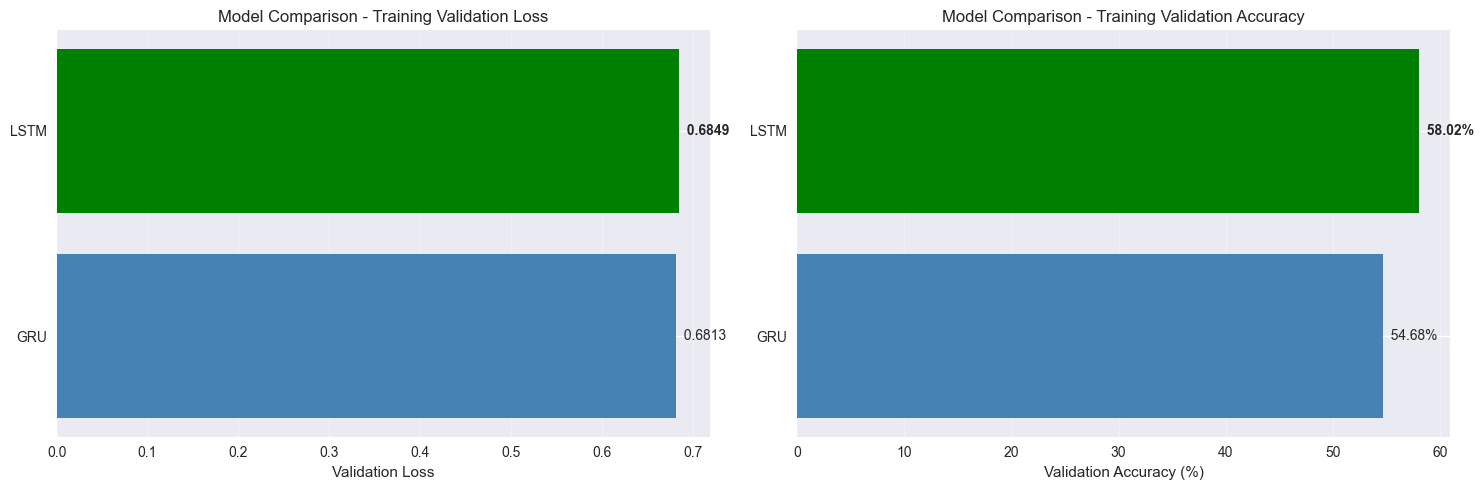

In [6]:
# Visualize model comparison
if evaluation_results and len(evaluation_results) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    comparison_df_viz = pd.DataFrame(evaluation_results).sort_values('Val Loss')
    
    # 1. Validation Loss Comparison
    ax1 = axes[0, 0]
    bars1 = ax1.barh(comparison_df_viz['Model'], comparison_df_viz['Val Loss'], 
                     color=['green' if m == best_model_name else 'steelblue' for m in comparison_df_viz['Model']])
    ax1.set_xlabel('Validation Loss')
    ax1.set_title('Model Comparison - Validation Loss')
    ax1.grid(True, alpha=0.3, axis='x')
    for i, (idx, row) in enumerate(comparison_df_viz.iterrows()):
        ax1.text(row['Val Loss'], i, f"  {row['Val Loss']:.4f}", 
                va='center', fontweight='bold' if row['Model'] == best_model_name else 'normal')
    
    # 2. Validation Accuracy Comparison
    ax2 = axes[0, 1]
    bars2 = ax2.barh(comparison_df_viz['Model'], comparison_df_viz['Val Accuracy'],
                     color=['green' if m == best_model_name else 'steelblue' for m in comparison_df_viz['Model']])
    ax2.set_xlabel('Validation Accuracy (%)')
    ax2.set_title('Model Comparison - Validation Accuracy')
    ax2.grid(True, alpha=0.3, axis='x')
    for i, (idx, row) in enumerate(comparison_df_viz.iterrows()):
        ax2.text(row['Val Accuracy'], i, f"  {row['Val Accuracy']:.2f}%", 
                va='center', fontweight='bold' if row['Model'] == best_model_name else 'normal')
    
    # 3. Test Loss Comparison
    ax3 = axes[1, 0]
    bars3 = ax3.barh(comparison_df_viz['Model'], comparison_df_viz['Test Loss'],
                     color=['green' if m == best_model_name else 'steelblue' for m in comparison_df_viz['Model']])
    ax3.set_xlabel('Test Loss')
    ax3.set_title('Model Comparison - Test Loss')
    ax3.grid(True, alpha=0.3, axis='x')
    for i, (idx, row) in enumerate(comparison_df_viz.iterrows()):
        ax3.text(row['Test Loss'], i, f"  {row['Test Loss']:.4f}", 
                va='center', fontweight='bold' if row['Model'] == best_model_name else 'normal')
    
    # 4. Test Accuracy Comparison
    ax4 = axes[1, 1]
    bars4 = ax4.barh(comparison_df_viz['Model'], comparison_df_viz['Test Accuracy'],
                     color=['green' if m == best_model_name else 'steelblue' for m in comparison_df_viz['Model']])
    ax4.set_xlabel('Test Accuracy (%)')
    ax4.set_title('Model Comparison - Test Accuracy')
    ax4.grid(True, alpha=0.3, axis='x')
    for i, (idx, row) in enumerate(comparison_df_viz.iterrows()):
        ax4.text(row['Test Accuracy'], i, f"  {row['Test Accuracy']:.2f}%", 
                va='center', fontweight='bold' if row['Model'] == best_model_name else 'normal')
    
    plt.tight_layout()
    plt.savefig('../models/model_comparison.png', dpi=150, bbox_inches='tight')
    print("\n✓ Saved model comparison plots to ../models/model_comparison.png")
    plt.show()
    
elif training_comparison:
    # If we only have training results, visualize those
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    training_df_viz = pd.DataFrame([
        {
            'Model': name,
            'Val Loss': results['val_loss'],
            'Val Accuracy': results['val_accuracy']
        }
        for name, results in training_comparison.items()
    ]).sort_values('Val Loss')
    
    # Training Validation Loss
    ax1 = axes[0]
    bars1 = ax1.barh(training_df_viz['Model'], training_df_viz['Val Loss'],
                     color=['green' if m == best_model_name else 'steelblue' for m in training_df_viz['Model']])
    ax1.set_xlabel('Validation Loss')
    ax1.set_title('Model Comparison - Training Validation Loss')
    ax1.grid(True, alpha=0.3, axis='x')
    for i, (idx, row) in enumerate(training_df_viz.iterrows()):
        ax1.text(row['Val Loss'], i, f"  {row['Val Loss']:.4f}", 
                va='center', fontweight='bold' if row['Model'] == best_model_name else 'normal')
    
    # Training Validation Accuracy
    ax2 = axes[1]
    bars2 = ax2.barh(training_df_viz['Model'], training_df_viz['Val Accuracy'],
                     color=['green' if m == best_model_name else 'steelblue' for m in training_df_viz['Model']])
    ax2.set_xlabel('Validation Accuracy (%)')
    ax2.set_title('Model Comparison - Training Validation Accuracy')
    ax2.grid(True, alpha=0.3, axis='x')
    for i, (idx, row) in enumerate(training_df_viz.iterrows()):
        ax2.text(row['Val Accuracy'], i, f"  {row['Val Accuracy']:.2f}%", 
                va='center', fontweight='bold' if row['Model'] == best_model_name else 'normal')
    
    plt.tight_layout()
    plt.savefig('../models/model_comparison_training.png', dpi=150, bbox_inches='tight')
    print("\n✓ Saved training comparison plots to ../models/model_comparison_training.png")
    plt.show()

## 3.6. Detailed Evaluation for Each Model

Detailed metrics (precision, recall, F1, confusion matrix) for each model, similar to training notebook.

In [7]:
# Detailed evaluation for each model (same format as training notebook)
if evaluation_results:
    for model_result in comparison_df.itertuples():
        model_name = model_result.Model
        
        print(f"\n{'='*60}")
        print(f"Detailed Evaluation: {model_name}")
        print(f"{'='*60}")
        
        # Rebuild and load model for detailed evaluation
        model = model_builders[model_name]()
        loss_fn = BinaryCrossEntropy(from_logits=False)
        model.set_loss(loss_fn)
        optimizer = Adam(learning_rate=0.001)
        trainer = Trainer(model, optimizer, loss_fn)
        
        # Load parameters
        params_file = model_dir / f"{model_name.lower()}_params.pkl"
        if params_file.exists():
            with open(params_file, "rb") as f:
                params = pickle.load(f)
        else:
            params = best_params  # Use best model params if this is the best model
        
        model.set_params(params)
        
        # Validation set detailed metrics
        print(f"\nValidation Set Metrics:")
        y_val_pred = trainer.predict(X_val)
        y_val_pred_binary = (y_val_pred > 0.5).astype(int).flatten()
        
        val_precision = precision_score(y_val, y_val_pred_binary, zero_division=0)
        val_recall = recall_score(y_val, y_val_pred_binary, zero_division=0)
        val_f1 = f1_score(y_val, y_val_pred_binary, zero_division=0)
        
        print(f"  Precision: {val_precision:.4f}")
        print(f"  Recall: {val_recall:.4f}")
        print(f"  F1-Score: {val_f1:.4f}")
        
        cm_val_detailed = confusion_matrix(y_val, y_val_pred_binary)
        print(f"\n  Confusion Matrix:")
        print(f"                Predicted")
        print(f"              ↓ (0)   ↑ (1)")
        print(f"Actual ↓ (0)  {cm_val_detailed[0,0]:6d}  {cm_val_detailed[0,1]:6d}")
        print(f"       ↑ (1)  {cm_val_detailed[1,0]:6d}  {cm_val_detailed[1,1]:6d}")
        
        # Test set detailed metrics
        print(f"\nTest Set Metrics:")
        y_test_pred = trainer.predict(X_test)
        y_test_pred_binary = (y_test_pred > 0.5).astype(int).flatten()
        
        test_precision = precision_score(y_test, y_test_pred_binary, zero_division=0)
        test_recall = recall_score(y_test, y_test_pred_binary, zero_division=0)
        test_f1 = f1_score(y_test, y_test_pred_binary, zero_division=0)
        
        print(f"  Precision: {test_precision:.4f}")
        print(f"  Recall: {test_recall:.4f}")
        print(f"  F1-Score: {test_f1:.4f}")
        
        cm_test_detailed = confusion_matrix(y_test, y_test_pred_binary)
        print(f"\n  Confusion Matrix:")
        print(f"                Predicted")
        print(f"              ↓ (0)   ↑ (1)")
        print(f"Actual ↓ (0)  {cm_test_detailed[0,0]:6d}  {cm_test_detailed[0,1]:6d}")
        print(f"       ↑ (1)  {cm_test_detailed[1,0]:6d}  {cm_test_detailed[1,1]:6d}")
        
        print(f"\n  Classification Report (Validation):")
        print(classification_report(y_val, y_val_pred_binary, target_names=['↓ Lower', '↑ Higher']))
        
        print(f"\n  Classification Report (Test):")
        print(classification_report(y_test, y_test_pred_binary, target_names=['↓ Lower', '↑ Higher']))
        
else:
    print("\n⚠ Only best model parameters available. Showing detailed evaluation for best model only.")
    print("   (See sections 4-5 for detailed evaluation of best model)")


⚠ Only best model parameters available. Showing detailed evaluation for best model only.
   (See sections 4-5 for detailed evaluation of best model)


## 4. Evaluate on Validation Set

In [8]:
# Evaluate on validation set
print("="*60)
print("Validation Set Evaluation")
print("="*60)

val_loss, val_accuracy = trainer.evaluate(X_val, y_val.reshape(-1, 1))
print(f"\nLoss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.2f}%")

# Make predictions
y_val_pred = trainer.predict(X_val)
y_val_pred_proba = y_val_pred.flatten()
y_val_pred_binary = (y_val_pred_proba > 0.5).astype(int)

# Calculate metrics
precision = precision_score(y_val, y_val_pred_binary, zero_division=0)
recall = recall_score(y_val, y_val_pred_binary, zero_division=0)
f1 = f1_score(y_val, y_val_pred_binary, zero_division=0)

try:
    auc = roc_auc_score(y_val, y_val_pred_proba)
    print(f"AUC-ROC: {auc:.4f}")
except:
    auc = None
    print("AUC-ROC: Could not calculate (possibly only one class)")

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion matrix
cm_val = confusion_matrix(y_val, y_val_pred_binary)
print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"              ↓ (0)   ↑ (1)")
print(f"Actual ↓ (0)  {cm_val[0,0]:6d}  {cm_val[0,1]:6d}")
print(f"       ↑ (1)  {cm_val[1,0]:6d}  {cm_val[1,1]:6d}")

print(f"\nClassification Report:")
print(classification_report(y_val, y_val_pred_binary, target_names=['↓ Lower', '↑ Higher']))

Validation Set Evaluation


ValueError: shapes (50000,64) and (48,48) not aligned: 64 (dim 1) != 48 (dim 0)

## 4.5. Threshold Optimization

Find optimal decision threshold to improve performance on imbalanced data.

In [ ]:
# Threshold Optimization - Find optimal threshold for imbalanced data
print("="*60)
print("Threshold Optimization")
print("="*60)

# Get validation predictions (probabilities)
y_val_pred_proba = trainer.predict(X_val).flatten()

# Method 1: Find threshold that maximizes F1-score
print("\nMethod 1: Maximizing F1-Score")
f1_scores = []
thresholds_f1 = np.linspace(0.1, 0.9, 81)  # Test thresholds from 0.1 to 0.9

for threshold in thresholds_f1:
    y_pred_thresh = (y_val_pred_proba >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred_thresh, zero_division=0)
    f1_scores.append(f1)

optimal_idx_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = thresholds_f1[optimal_idx_f1]
optimal_f1 = f1_scores[optimal_idx_f1]

print(f"  Optimal Threshold (F1): {optimal_threshold_f1:.4f}")
print(f"  F1-Score at optimal threshold: {optimal_f1:.4f}")

# Method 2: Find threshold that maximizes Youden's J statistic (TPR - FPR)
print("\nMethod 2: Maximizing Youden's J (TPR - FPR)")
fpr, tpr, thresholds_roc = roc_curve(y_val, y_val_pred_proba)
youden_j = tpr - fpr
optimal_idx_j = np.argmax(youden_j)
optimal_threshold_j = thresholds_roc[optimal_idx_j]
optimal_j = youden_j[optimal_idx_j]

print(f"  Optimal Threshold (Youden's J): {optimal_threshold_j:.4f}")
print(f"  Youden's J at optimal threshold: {optimal_j:.4f}")

# Method 3: Find threshold that balances precision and recall (closest to (1,1) on PR curve)
print("\nMethod 3: Balancing Precision and Recall")
precision, recall, thresholds_pr = precision_recall_curve(y_val, y_val_pred_proba)
# Find threshold closest to precision=1, recall=1
f1_scores_pr = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx_pr = np.argmax(f1_scores_pr)
optimal_threshold_pr = thresholds_pr[optimal_idx_pr] if optimal_idx_pr < len(thresholds_pr) else 0.5
optimal_f1_pr = f1_scores_pr[optimal_idx_pr]

print(f"  Optimal Threshold (PR Curve): {optimal_threshold_pr:.4f}")
print(f"  F1-Score at optimal threshold: {optimal_f1_pr:.4f}")

# Compare all methods
print("\n" + "="*60)
print("Comparison of Threshold Selection Methods")
print("="*60)

thresholds_to_test = {
    'Default (0.5)': 0.5,
    'F1-Maximized': optimal_threshold_f1,
    'Youden\'s J': optimal_threshold_j,
    'PR-Curve': optimal_threshold_pr
}

threshold_results = []
for method_name, threshold in thresholds_to_test.items():
    y_pred_thresh = (y_val_pred_proba >= threshold).astype(int)
    acc = accuracy_score(y_val, y_pred_thresh)
    prec = precision_score(y_val, y_pred_thresh, zero_division=0)
    rec = recall_score(y_val, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_val, y_pred_thresh, zero_division=0)
    
    threshold_results.append({
        'Method': method_name,
        'Threshold': threshold,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

threshold_comparison_df = pd.DataFrame(threshold_results)
print("\n" + threshold_comparison_df.to_string(index=False))

# Select best threshold (prioritize F1-score for imbalanced data)
best_method = threshold_comparison_df.loc[threshold_comparison_df['F1-Score'].idxmax(), 'Method']
optimal_threshold = thresholds_to_test[best_method]

print(f"\n{'='*60}")
print(f"✓ Selected Optimal Threshold: {optimal_threshold:.4f} ({best_method})")
print(f"{'='*60}")

# Visualize threshold selection
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. F1-Score vs Threshold
ax1 = axes[0, 0]
ax1.plot(thresholds_f1, f1_scores, 'b-', linewidth=2, label='F1-Score')
ax1.axvline(optimal_threshold_f1, color='r', linestyle='--', label=f'Optimal: {optimal_threshold_f1:.3f}')
ax1.axvline(0.5, color='g', linestyle='--', alpha=0.5, label='Default: 0.5')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('F1-Score')
ax1.set_title('F1-Score vs Threshold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. ROC Curve with optimal threshold
ax2 = axes[0, 1]
ax2.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {roc_auc_score(y_val, y_val_pred_proba):.3f})')
ax2.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
# Mark optimal threshold point
optimal_fpr = fpr[optimal_idx_j]
optimal_tpr = tpr[optimal_idx_j]
ax2.plot(optimal_fpr, optimal_tpr, 'ro', markersize=10, label=f'Optimal Threshold: {optimal_threshold_j:.3f}')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve with Optimal Threshold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Precision-Recall Curve
ax3 = axes[1, 0]
ax3.plot(recall, precision, 'b-', linewidth=2, label='PR Curve')
# Mark optimal threshold
optimal_prec = precision[optimal_idx_pr]
optimal_rec = recall[optimal_idx_pr]
ax3.plot(optimal_rec, optimal_prec, 'ro', markersize=10, label=f'Optimal Threshold: {optimal_threshold_pr:.3f}')
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision-Recall Curve')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Metrics comparison
ax4 = axes[1, 1]
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(threshold_comparison_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    offset = (i - 1.5) * width
    values = threshold_comparison_df[metric].values
    ax4.bar(x_pos + offset, values, width, label=metric, alpha=0.7)

ax4.set_xlabel('Threshold Method')
ax4.set_ylabel('Score')
ax4.set_title('Metrics Comparison Across Thresholds')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(threshold_comparison_df['Method'], rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../models/threshold_optimization.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved threshold optimization plots to ../models/threshold_optimization.png")
plt.show()

# Store optimal threshold for use in test evaluation
print(f"\n💡 Using threshold {optimal_threshold:.4f} for test set evaluation")

Threshold Optimization


ValueError: shapes (50000,64) and (48,48) not aligned: 64 (dim 1) != 48 (dim 0)

## 5. Evaluate on Test Set

In [ ]:
# Evaluate on test set with optimal threshold
print("="*60)
print("Test Set Evaluation (with Optimal Threshold)")
print("="*60)

test_loss, test_accuracy = trainer.evaluate(X_test, y_test.reshape(-1, 1))
print(f"\nLoss: {test_loss:.4f}")
print(f"Accuracy (at default 0.5): {test_accuracy:.2f}%")

# Make predictions
y_test_pred = trainer.predict(X_test)
y_test_pred_proba = y_test_pred.flatten()

# Use optimal threshold from validation set
try:
    # Use optimal threshold if it was computed
    y_test_pred_binary_optimal = (y_test_pred_proba >= optimal_threshold).astype(int)
    print(f"\nUsing optimal threshold: {optimal_threshold:.4f}")
except NameError:
    # Fallback to 0.5 if threshold optimization wasn't run
    optimal_threshold = 0.5
    y_test_pred_binary_optimal = (y_test_pred_proba >= optimal_threshold).astype(int)
    print(f"\nUsing default threshold: 0.5 (run threshold optimization first)")

# Also calculate with default threshold for comparison
y_test_pred_binary_default = (y_test_pred_proba > 0.5).astype(int)

# Calculate metrics with optimal threshold
test_precision_opt = precision_score(y_test, y_test_pred_binary_optimal, zero_division=0)
test_recall_opt = recall_score(y_test, y_test_pred_binary_optimal, zero_division=0)
test_f1_opt = f1_score(y_test, y_test_pred_binary_optimal, zero_division=0)
test_accuracy_opt = accuracy_score(y_test, y_test_pred_binary_optimal)

# Calculate metrics with default threshold
test_precision_def = precision_score(y_test, y_test_pred_binary_default, zero_division=0)
test_recall_def = recall_score(y_test, y_test_pred_binary_default, zero_division=0)
test_f1_def = f1_score(y_test, y_test_pred_binary_default, zero_division=0)
test_accuracy_def = accuracy_score(y_test, y_test_pred_binary_default)

try:
    test_auc = roc_auc_score(y_test, y_test_pred_proba)
    print(f"AUC-ROC: {test_auc:.4f}")
except:
    test_auc = None

print(f"\n{'='*60}")
print("Performance Comparison: Default vs Optimal Threshold")
print(f"{'='*60}")
print(f"\nDefault Threshold (0.5):")
print(f"  Accuracy: {test_accuracy_def:.4f}")
print(f"  Precision: {test_precision_def:.4f}")
print(f"  Recall: {test_recall_def:.4f}")
print(f"  F1-Score: {test_f1_def:.4f}")

print(f"\nOptimal Threshold ({optimal_threshold:.4f}):")
print(f"  Accuracy: {test_accuracy_opt:.4f}")
print(f"  Precision: {test_precision_opt:.4f}")
print(f"  Recall: {test_recall_opt:.4f}")
print(f"  F1-Score: {test_f1_opt:.4f}")

print(f"\nImprovement:")
print(f"  Accuracy: {test_accuracy_opt - test_accuracy_def:+.4f} ({((test_accuracy_opt - test_accuracy_def)/test_accuracy_def*100):+.2f}%)")
print(f"  Precision: {test_precision_opt - test_precision_def:+.4f} ({((test_precision_opt - test_precision_def)/test_precision_def*100):+.2f}%)")
print(f"  Recall: {test_recall_opt - test_recall_def:+.4f} ({((test_recall_opt - test_recall_def)/test_recall_def*100):+.2f}%)")
print(f"  F1-Score: {test_f1_opt - test_f1_def:+.4f} ({((test_f1_opt - test_f1_def)/test_f1_def*100):+.2f}%)")

# Use optimal threshold for confusion matrix and classification report
y_test_pred_binary = y_test_pred_binary_optimal
test_precision = test_precision_opt
test_recall = test_recall_opt
test_f1 = test_f1_opt
test_accuracy = test_accuracy_opt * 100  # Convert to percentage

# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred_binary)
print(f"\n{'='*60}")
print("Confusion Matrix (with Optimal Threshold):")
print(f"{'='*60}")
print(f"                Predicted")
print(f"              ↓ (0)   ↑ (1)")
print(f"Actual ↓ (0)  {cm_test[0,0]:6d}  {cm_test[0,1]:6d}")
print(f"       ↑ (1)  {cm_test[1,0]:6d}  {cm_test[1,1]:6d}")

print(f"\nClassification Report (with Optimal Threshold):")
print(classification_report(y_test, y_test_pred_binary, target_names=['↓ Lower', '↑ Higher']))

Test Set Evaluation (with Optimal Threshold)


ValueError: shapes (100000,64) and (48,48) not aligned: 64 (dim 1) != 48 (dim 0)

## 6. Visualizations

NameError: name 'cm_val' is not defined

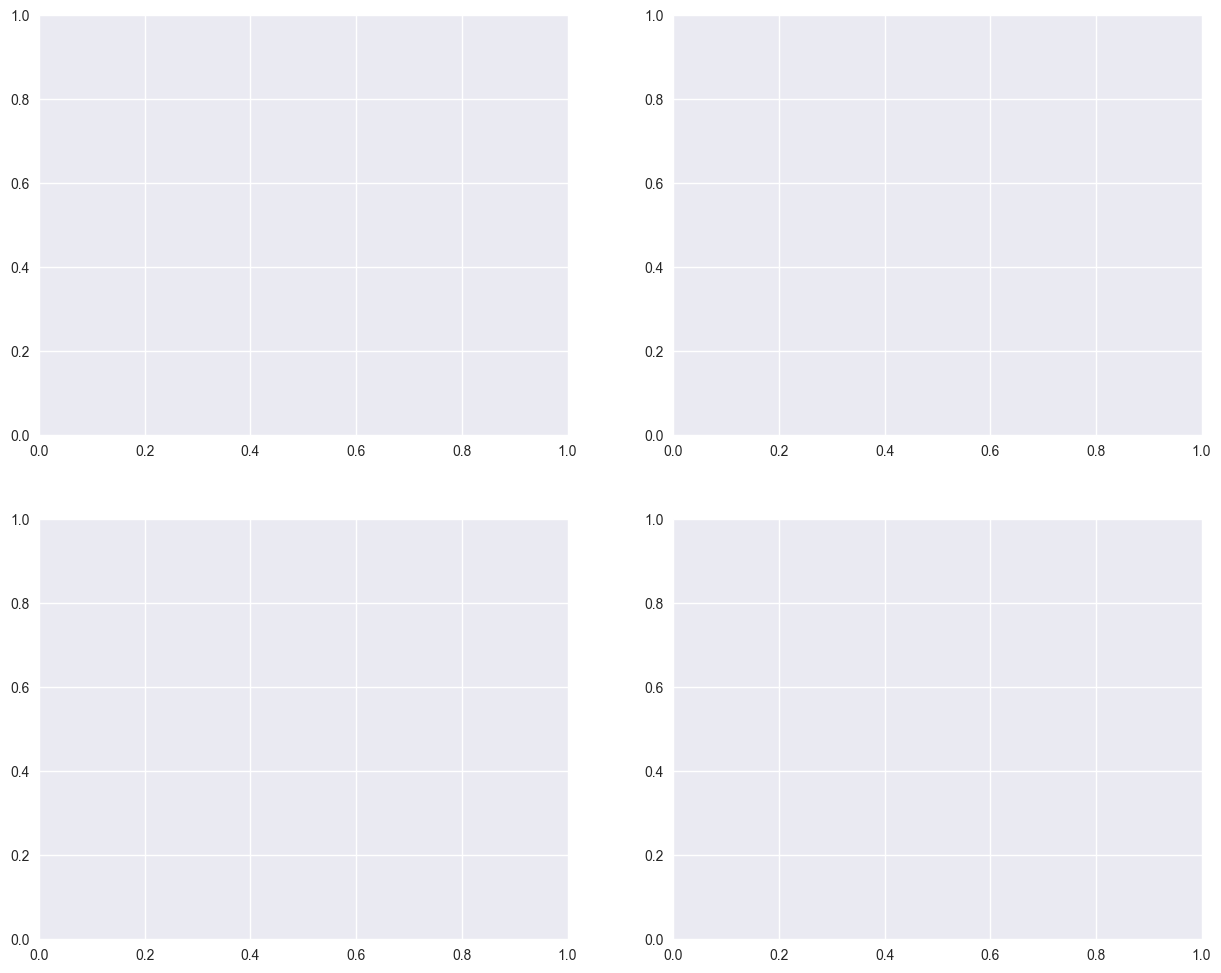

In [ ]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix - Validation
ax1 = axes[0, 0]
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['↓ Lower', '↑ Higher'],
            yticklabels=['↓ Lower', '↑ Higher'])
ax1.set_title(f'Confusion Matrix - Validation Set\nAccuracy: {val_accuracy:.2f}%')
ax1.set_ylabel('Actual')
ax1.set_xlabel('Predicted')

# 2. Confusion Matrix - Test
ax2 = axes[0, 1]
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['↓ Lower', '↑ Higher'],
            yticklabels=['↓ Lower', '↑ Higher'])
try:
    threshold_label = f' (threshold: {optimal_threshold:.3f})'
except NameError:
    threshold_label = ' (threshold: 0.5)'
ax2.set_title(f'Confusion Matrix - Test Set\nAccuracy: {test_accuracy:.2f}%{threshold_label}')
ax2.set_ylabel('Actual')
ax2.set_xlabel('Predicted')

# 3. Prediction Probability Distribution
ax3 = axes[1, 0]
ax3.hist(y_val_pred_proba[y_val == 0], bins=50, alpha=0.5, label='Actual ↓ Lower', color='red')
ax3.hist(y_val_pred_proba[y_val == 1], bins=50, alpha=0.5, label='Actual ↑ Higher', color='green')
try:
    ax3.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal Threshold: {optimal_threshold:.3f}')
    ax3.axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Default: 0.5')
except NameError:
    ax3.axvline(x=0.5, color='black', linestyle='--', label='Decision Threshold: 0.5')
ax3.set_xlabel('Predicted Probability')
ax3.set_ylabel('Frequency')
ax3.set_title('Prediction Probability Distribution - Validation')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. ROC Curve (if AUC available)
ax4 = axes[1, 1]
if auc is not None:
    fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
    ax4.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', linewidth=2)
    ax4.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    try:
        # Mark optimal threshold on ROC curve
        optimal_fpr_idx = np.argmin(np.abs(thresholds - optimal_threshold))
        ax4.plot(fpr[optimal_fpr_idx], tpr[optimal_fpr_idx], 'ro', markersize=10, 
                label=f'Optimal Threshold: {optimal_threshold:.3f}')
    except NameError:
        pass
    ax4.set_xlabel('False Positive Rate')
    ax4.set_ylabel('True Positive Rate')
    ax4.set_title('ROC Curve - Validation Set')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'ROC Curve\nNot Available', 
             ha='center', va='center', fontsize=12)
    ax4.set_title('ROC Curve - Validation Set')

plt.tight_layout()
plt.savefig('../models/evaluation_plots.png', dpi=150, bbox_inches='tight')
print("✓ Saved evaluation plots to ../models/evaluation_plots.png")
plt.show()

## 7. Per-Ticker Performance Analysis

In [ ]:
# Analyze performance per ticker
ticker_performance = []

for ticker in np.unique(tickers_val):
    ticker_mask = tickers_val == ticker
    if ticker_mask.sum() == 0:
        continue
    
    ticker_y_true = y_val[ticker_mask]
    ticker_y_pred = y_val_pred_binary[ticker_mask]
    
    ticker_acc = accuracy_score(ticker_y_true, ticker_y_pred)
    ticker_precision = precision_score(ticker_y_true, ticker_y_pred, zero_division=0)
    ticker_recall = recall_score(ticker_y_true, ticker_y_pred, zero_division=0)
    ticker_f1 = f1_score(ticker_y_true, ticker_y_pred, zero_division=0)
    
    ticker_performance.append({
        'Ticker': ticker,
        'Samples': ticker_mask.sum(),
        'Accuracy': ticker_acc,
        'Precision': ticker_precision,
        'Recall': ticker_recall,
        'F1': ticker_f1
    })

ticker_df = pd.DataFrame(ticker_performance).sort_values('Accuracy', ascending=False)

print("="*60)
print("Top 10 Best Performing Tickers (Validation)")
print("="*60)
print(ticker_df.head(10).to_string(index=False))

print(f"\n{'='*60}")
print("Bottom 10 Worst Performing Tickers (Validation)")
print("="*60)
print(ticker_df.tail(10).to_string(index=False))

print(f"\n{'='*60}")
print("Overall Ticker Statistics")
print("="*60)
print(f"Mean Accuracy: {ticker_df['Accuracy'].mean():.4f}")
print(f"Std Accuracy: {ticker_df['Accuracy'].std():.4f}")
print(f"Min Accuracy: {ticker_df['Accuracy'].min():.4f}")
print(f"Max Accuracy: {ticker_df['Accuracy'].max():.4f}")

# Visualize ticker performance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy distribution
axes[0].hist(ticker_df['Accuracy'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(ticker_df['Accuracy'].mean(), color='red', linestyle='--', 
                label=f'Mean: {ticker_df["Accuracy"].mean():.3f}')
axes[0].set_xlabel('Accuracy')
axes[0].set_ylabel('Number of Tickers')
axes[0].set_title('Accuracy Distribution Across Tickers')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Top/Bottom tickers
top_n = 15
top_tickers = ticker_df.head(top_n)
bottom_tickers = ticker_df.tail(top_n)

axes[1].barh(range(len(top_tickers)), top_tickers['Accuracy'], 
             label='Top Tickers', color='green', alpha=0.7)
axes[1].barh(range(len(top_tickers), len(top_tickers) + len(bottom_tickers)),
             bottom_tickers['Accuracy'], label='Bottom Tickers', color='red', alpha=0.7)
axes[1].set_yticks(range(len(top_tickers) + len(bottom_tickers)))
axes[1].set_yticklabels(list(top_tickers['Ticker']) + list(bottom_tickers['Ticker']))
axes[1].set_xlabel('Accuracy')
axes[1].set_title(f'Top {top_n} and Bottom {top_n} Tickers by Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../models/ticker_performance.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved ticker performance plots to ../models/ticker_performance.png")
plt.show()

NameError: name 'y_val_pred_binary' is not defined

In [ ]:
# Analyze performance over time
val_results_df = pd.DataFrame({
    'Date': pd.to_datetime(dates_val),
    'Ticker': tickers_val,
    'Actual': y_val,
    'Predicted': y_val_pred_binary,
    'Probability': y_val_pred_proba,
    'Correct': (y_val == y_val_pred_binary).astype(int)
})

val_results_df['Year'] = val_results_df['Date'].dt.year
val_results_df['Month'] = val_results_df['Date'].dt.month
val_results_df['Quarter'] = val_results_df['Date'].dt.quarter

# Performance by year
yearly_perf = val_results_df.groupby('Year').agg({
    'Correct': ['mean', 'count']
}).reset_index()
yearly_perf.columns = ['Year', 'Accuracy', 'Count']

print("="*60)
print("Performance by Year (Validation)")
print("="*60)
print(yearly_perf.to_string(index=False))

# Performance by month
monthly_perf = val_results_df.groupby('Month').agg({
    'Correct': 'mean'
}).reset_index()
monthly_perf.columns = ['Month', 'Accuracy']

print(f"\n{'='*60}")
print("Performance by Month (Validation)")
print("="*60)
print(monthly_perf.to_string(index=False))

# Visualize temporal performance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Yearly performance
axes[0].bar(yearly_perf['Year'], yearly_perf['Accuracy'], alpha=0.7, edgecolor='black')
axes[0].axhline(val_accuracy/100, color='red', linestyle='--', 
                label=f'Overall: {val_accuracy:.2f}%')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy by Year')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Monthly performance
axes[1].plot(monthly_perf['Month'], monthly_perf['Accuracy'], 
             marker='o', linewidth=2, markersize=8)
axes[1].axhline(val_accuracy/100, color='red', linestyle='--', 
                label=f'Overall: {val_accuracy:.2f}%')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy by Month')
axes[1].set_xticks(range(1, 13))
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/temporal_performance.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved temporal performance plots to ../models/temporal_performance.png")
plt.show()

NameError: name 'y_val_pred_binary' is not defined

## 9. Summary

Evaluation complete! Key findings:
- Model performance on validation and test sets
- Per-ticker analysis shows which stocks are easier/harder to predict
- Temporal analysis shows performance over time
- All plots saved to `../models/` directory